Patch TST 模型是假设通道独立的，所谓通道独立，就是把每个时间序列都当作独立的时间序列，把面板数据降维到时间序列级别，再说难听一点就是忽略截面关系。这样的选择有一定道理，因为首先其实绝大部分时间序列的关系确实是微弱的，建模截面关系只会徒增复杂度，效果并不好，为过拟合控制带来额外的成本

这样的假设导致了我们在训练输出层的时候，不能把所有的资产都加入到训练中，只能一个板块训练，然后用于预测一个板块，不同板块的资产，其变化模式的差异较大，只用单一输出层拟合所有资产带来的损失过大。

但是金融市场的资产相关性是很强的，对于期货市场而言，既可以发掘板块内高相似性资产的套利关系，也可以发掘股指期货、国债期货、商品期货和贵金属期货、农产品期货的板块轮动关系，抛弃掉这样的关系未免太可惜了。

对此，我提出一种强相关性资产截面建模的模式，可以同时起到数据增强和因子挖掘的效果：

1. 定义一组可以多空交易的资产，称为基资产(base assets)，基资产之间最好有较强的统计关系，覆盖面要足够广

2. 任意基资产的多空组合（实际中控制多空比例和总仓位）称为组合资产。传统对于时间序列数据不足的问题有方法通过人工生成数据，但这些数据现实中不存在，对模型的指导意义存疑。由于期货市场的特性，组合资产是实在可交易的一种切实存在的金融资产，避免了传统人工生成的数据缺少实际意义的问题。

3. 基资产也可以视为一个特殊的组合资产（单资产比例为100%）

4. 定义一个可学习的嵌入，将每种基资产嵌入到高维空间的一个向量

5. 任意组合资产的嵌入向量即使其基资产的高维嵌入的线性组合。例如假设C的嵌入是（0.2，0.3，0.5...） M的嵌入是（0.8，0.6，0.1...），则 70%C+30%M 的组合资产（即饲料，是有真实经济意义的资产组合）的嵌入即为（0.28，0.39，0.36...）

6. 到这里其实已经很接近传统模型了，嵌入的各个维度实际上就是某种“因子”，或者说某种方向的 Risk Exposure，例如利率、通胀等等。一个投资组合的风险暴露或其它特性理应是其成分资产风险暴露的加权平均。这种结构化的约束或称归纳偏置使得嵌入空间的学习更加高效和有意义，避免了模型学到毫无逻辑的表征。

7. 组合资产同样有价格时间序列，也有了嵌入表示，我们就可以将生成的组合资产加入到训练集中，大大弥补训练数据不足的问题；

8. 而且这样的模式是端到端的。传统因子模型需要先验地定义因子（如市值、估值）。而维度不是预先定义的，而是模型学习出来的，比人为定义更科学，甚至可能能发现新的因子。

下一个问题就是，如何预训练这个assets embedding呢？还是回到原假设，投资组合的风险暴露是其成分资产风险暴露的加权平均。

由于基资产之间不可能是完全正交的，任意一种基资产应当可以被其他资产线性表出。我们随机选择一个基资产At当作组合资产，然后以其他基资产(A1,A2...)作为基向量，通过求解线性方程组的形式，得到一个目标基资产的线性组合表出：

At = f1 * A1 + f2 * A2....

然后我们随机选取一个时间段，计算这个时间段内每个资产的年化收益率，用(A1,A2...)的收益率与权重估计At的收益率，然后与真实的At收益率对比，计算L1 loss 并反向传播，更新embedding 的参数

当然，由于维度小于资产总数，线性表出的方式不止一种，我们希望的是找到其中权重参数绝对值最小的一组，即线性方程组的最小范数解。

同时为了提高效率，我们可以同时选取多个目标基资产，虽然能找到的最小范数解并不一定是最优，但执行效率更高，可以向量化处理，解出伪逆矩阵就可以得到最小范数解

In [177]:
import torch
device = 'cuda:0'

# 总资产数 = 30，维度 = 10，目标资产 = 5
A_embedding = torch.randn(size = (10, 30), device=device)

# 根据随机数选择目标资产
target_indices = torch.randperm(30, device=device)[:5]
A_target = A_embedding[:, target_indices]

# 剩余部分作为基向量
mask = torch.ones(30, dtype=torch.bool, device=device)
mask[target_indices] = False
A_base = A_embedding[:, mask]

# 解出伪逆矩阵
A_base_pinv = torch.linalg.pinv(A_base)

# 最小范数解即为
X = A_base_pinv @ A_target

print(f"embedding              : {A_embedding.shape}")
print(f"target                 : {A_target.shape}")
print(f"base                   : {A_base.shape}")
print(f"pseudoinverse          : {A_base_pinv.shape}")
print(f"minimized norm solution: {X.shape}")

embedding              : torch.Size([10, 30])
target                 : torch.Size([10, 5])
base                   : torch.Size([10, 25])
pseudoinverse          : torch.Size([25, 10])
minimized norm solution: torch.Size([25, 5])


In [ ]:
import torch
import torch.nn as nn
import math

class AssetsEmbedding(nn.Module):
    def __init__(self, num_assets, embedding_dim, target_ratio = 0.2):
        super().__init__()
        self.num_assets = num_assets
        self.embedding_dim  = embedding_dim
        # 设置目标资产的比例
        self.num_target = math.ceil((num_assets - embedding_dim) * target_ratio)
        # 定义嵌入层
        self.embedding = nn.Embedding(num_embeddings = num_assets, embedding_dim = embedding_dim)

    def forward(self, x):
        return self.embedding(x)
    
    def pre_train(self, x):
        """
        预训练，现在每次输入的x是一个批次的收益率数据
        x 的形状: (batch_size, num_assets)
        返回: x_pred, x_real, 形状均为 (batch_size, 5)
        """
        # 对于整个批次，我们选择相同的目标和基准资产
        # 索引目标资产和基准资产
        target_indices = torch.randperm(self.num_assets, device = x.device)[:self.num_target]
        mask = torch.ones(self.num_assets, dtype=torch.bool, device = x.device)
        mask[target_indices] = False

        # 分离预测目标和基向量的嵌入
        A_target = self.embedding.weight[target_indices]
        A_base = self.embedding.weight[mask]

        # 求解方程组，这个 solution 矩阵对于整个批次是通用的
        solution = torch.linalg.lstsq(A_base.T, A_target.T).solution
        
        # 映射线性关系到批次的收益率上
        # 从批次数据中选取所有样本的目标资产真实收益率
        # x 形状 (batch_size, num_assets) -> x_real 形状 (batch_size, self.num_target)
        x_real = x[:, target_indices] 

        # 从批次数据中选取所有样本的基准资产真实收益率
        # x 形状 (batch_size, num_assets) -> x_base 形状 (batch_size, num_assets - self.num_target)
        x_base = x[:, mask]
        x_pred = x_base @ solution 
        
        return x_pred, x_real

model =  AssetsEmbedding(30, 10).to('cuda:0')
loss_fn = nn.L1Loss()
x = torch.randn(size = (32, 30), device = 'cuda:0')
x_pred, x_real = model.pre_train(x)
print(x_pred.shape, x_real.shape)

torch.Size([32, 4]) torch.Size([32, 4])


选取标准为上市历史超过1000个交易日，且最近100个交易日主力合约日均持仓量大于50000。交易持仓量过小的合约可能陷入流动性问题，且其成交量往往也比较小，价格不够透明，滑点交易成本也比较高。

In [180]:
assets_list = [
    # 股指期货
    'IH.CFX', 'IF.CFX', 'IC.CFX',
    # 国债期货
    'TS.CFX', 'TF.CFX', 'T.CFX', 'TL.CFX',
    # 黑色金属产业链
    'I.DCE', 'JM.DCE', 'RB.SHF', 'HC.SHF', 'SS.SHF', 'SF.ZCE', 'SM.ZCE',
    # 有色金属
    'CU.SHF', 'AL.SHF', 'ZN.SHF', 'NI.SHF',
    # 贵金属
    'AU.SHF', 'AG.SHF',
    # 能源化工
    'FU.SHF', 'LU.INE', 'BU.SHF', 'PG.DCE', 'TA.ZCE', 'EG.DCE', 'PF.ZCE', 
    'L.DCE', 'PP.DCE', 'V.DCE', 'EB.DCE', 'MA.ZCE', 'UR.ZCE', 'RU.SHF',
    # 农产品
    'A.DCE', 'B.DCE', 'M.DCE', 'RM.ZCE', 'Y.DCE', 'OI.ZCE', 'P.DCE', 'PK.ZCE',
    'C.DCE', 'CS.DCE', 'CF.ZCE', 'SR.ZCE', 'CJ.ZCE', 'AP.ZCE', 'SP.SHF', 
    'JD.DCE', 'LH.DCE',
    # 建材
    'FG.ZCE', 'SA.ZCE'
]

In [181]:
assets_names = [
    # 股指期货
    '上证50', '沪深300', '中证500',
    # 国债期货
    '2年国债', '5年国债', '10年国债', '30年国债',
    # 黑色金属
    '铁矿石', '焦煤', '螺纹钢', '热轧卷板', '不锈钢', '硅铁', '锰硅',
    # 有色金属
    '沪铜', '沪铝', '沪锌', '沪镍',
    # 贵金属
    '黄金', '白银',
    # 能源化工
    '燃油', '低硫燃料油', '沥青', 'LPG', 'PTA', '乙二醇', '短纤', 
    '塑料', '聚丙烯', 'PVC', '苯乙烯', '甲醇', '尿素', '橡胶',
    # 农产品
    '豆一', '豆二', '豆粕', '菜粕', '豆油', '菜油', '棕榈油', '花生',
    '玉米', '玉米淀粉', '棉花', '白糖', '红枣', '苹果', '纸浆', 
    '鸡蛋', '生猪',
    # 建材
    '玻璃', '纯碱'
]

In [182]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import yaml
with open('config.yaml', 'r') as file:
    token = yaml.safe_load(file)['token']

import tushare as ts
pro = ts.pro_api(token)

In [183]:
# 提取日收益率数据
import numpy as np
import pandas as pd
daily_yield = []
for assets_code in assets_list:
    data = pro.fut_daily(ts_code = assets_code, start_date = '20210202', fields = 'trade_date, pre_close, close')
    assets_daily_yield = np.log(data['close']) - np.log(data['pre_close'])
    daily_yield.append(torch.tensor(assets_daily_yield.values, device = 'cuda:0', dtype = torch.float32))

daily_yield = torch.stack(daily_yield, dim = 0)

# 划分训练集和测试集
train_yield = daily_yield[:,:800]
test_yield = daily_yield[:,800:]

In [ ]:
import optuna
import tqdm
# 二阶段 prediction训练
def objective(trial):
    # 调优参数
    embedding_dim = trial.suggest_categorical("embedding_dim", [8,10,12,14,16])
    target_ratio = trial.suggest_float("target_ratio", 0.01, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-7, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-1, log=True)
    minimize_window = trial.suggest_int("minimize_window", 1, 100)
    batch_size = trial.suggest_categorical("batch_size", [128,256,512,1024])

    num_assets = len(assets_list)
    train_sample_range = train_yield.shape[1]
    test_sample_range = test_yield.shape[1]

    model = AssetsEmbedding(num_assets = num_assets, embedding_dim = embedding_dim, target_ratio = target_ratio).to('cuda:0')
    loss_fn = nn.HuberLoss()
    optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
    
    def batch(train_batch_size, test_batch_size):

        # 训练
        model.train()
        batch_yield = []
        begin = np.random.randint(0, train_sample_range - minimize_window, train_batch_size)
        end = np.array([np.random.randint(first+minimize_window, train_sample_range) for first in begin])
        for i in range(train_batch_size):
            range_yield = train_yield[:, begin[i]: end[i]]
            target_yield = torch.mean(range_yield, dim = 1)
            batch_yield.append(target_yield)
        batch_yield = torch.stack(batch_yield)

        x_pred, x_real = model.pre_train(batch_yield)
        optimizer.zero_grad()
        train_loss = loss_fn(x_pred, x_real)
        train_loss.backward()
        optimizer.step()

        # 测试
        model.eval()
        with torch.no_grad():
            batch_yield = []
            begin = np.random.randint(0, test_sample_range - minimize_window, test_batch_size)
            end = np.array([np.random.randint(first+minimize_window,test_sample_range) for first in begin])
            for i in range(test_batch_size):
                range_yield = test_yield[:, begin[i]: end[i]]
                target_yield = torch.mean(range_yield, dim = 1)
                batch_yield.append(target_yield)
            batch_yield = torch.stack(batch_yield)
            x_pred, x_real = model.pre_train(batch_yield)
            test_loss = loss_fn(x_pred, x_real)

        return train_loss.cpu().detach(), test_loss.cpu().detach()

    def train(round):
        train_losses = []
        test_losses = []
        for i in tqdm.tqdm(range(round)):
            train_loss, test_loss = batch(train_batch_size = batch_size, test_batch_size = batch_size)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        return np.min(test_losses)
    
    min_loss = train(10000)
    return min_loss

In [185]:
study = optuna.create_study(
    direction="minimize",
    study_name="assets_embed_1",
    storage="sqlite:///data/db.sqlite3_assets_embed_1",  # 保存到 SQLite 文件
    load_if_exists=True # 如果存在同名study，则加载它
)

study.optimize(objective, n_trials=50)

[I 2025-10-10 05:41:45,373] A new study created in RDB with name: assets_embed_1
100%|██████████| 10000/10000 [02:02<00:00, 81.90it/s]
[I 2025-10-10 05:43:47,589] Trial 0 finished with value: 6.105841521275579e-07 and parameters: {'embedding_dim': 14, 'target_ratio': 0.21245996322112576, 'learning_rate': 0.0022423049807778045, 'weight_decay': 8.304905767881481e-07, 'minimize_window': 39, 'batch_size': 128}. Best is trial 0 with value: 6.105841521275579e-07.
100%|██████████| 10000/10000 [02:09<00:00, 77.16it/s]
[I 2025-10-10 05:45:57,308] Trial 1 finished with value: 9.107062055591086e-07 and parameters: {'embedding_dim': 16, 'target_ratio': 0.377529656457951, 'learning_rate': 5.272016450273242e-06, 'weight_decay': 9.510242684465986e-05, 'minimize_window': 65, 'batch_size': 128}. Best is trial 0 with value: 6.105841521275579e-07.
100%|██████████| 10000/10000 [03:16<00:00, 50.89it/s]
[I 2025-10-10 05:49:13,933] Trial 2 finished with value: 3.999590262537822e-06 and parameters: {'embeddin

In [186]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [187]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [188]:
df = study.trials_dataframe()
df.sort_values(by='value', ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_embedding_dim,params_learning_rate,params_minimize_window,params_target_ratio,params_weight_decay,state
12,12,3.804108e-09,2025-10-10 06:28:11.812064,2025-10-10 06:33:08.420052,0 days 00:04:56.607988,512,12,9.354098e-02,98,0.015113,1.023069e-05,COMPLETE
10,10,8.794059e-09,2025-10-10 06:18:22.395831,2025-10-10 06:23:16.432498,0 days 00:04:54.036667,512,12,9.287618e-02,99,0.013041,3.357303e-05,COMPLETE
36,36,1.056865e-08,2025-10-10 08:11:12.358111,2025-10-10 08:13:30.477513,0 days 00:02:18.119402,256,12,4.845412e-02,75,0.034707,1.548235e-03,COMPLETE
42,42,1.085981e-08,2025-10-10 08:24:55.022891,2025-10-10 08:27:21.093170,0 days 00:02:26.070279,256,12,4.817184e-02,96,0.039691,1.436794e-03,COMPLETE
41,41,1.347579e-08,2025-10-10 08:22:33.971307,2025-10-10 08:24:55.008193,0 days 00:02:21.036886,256,12,5.075157e-02,89,0.030653,1.393884e-04,COMPLETE
32,32,1.707313e-08,2025-10-10 07:57:31.688774,2025-10-10 08:01:30.598724,0 days 00:03:58.909950,512,12,9.106434e-02,94,0.035340,6.504538e-05,COMPLETE
22,22,3.348184e-08,2025-10-10 07:15:56.522713,2025-10-10 07:19:54.485270,0 days 00:03:57.962557,512,12,9.823068e-02,90,0.025490,1.869856e-05,COMPLETE
31,31,3.492180e-08,2025-10-10 07:53:30.683796,2025-10-10 07:57:31.676429,0 days 00:04:00.992633,512,12,4.762199e-02,94,0.037589,1.610795e-05,COMPLETE
47,47,3.629247e-08,2025-10-10 08:36:53.704157,2025-10-10 08:39:21.503865,0 days 00:02:27.799708,256,12,4.923650e-02,80,0.063661,4.596253e-04,COMPLETE
45,45,3.709777e-08,2025-10-10 08:32:07.259907,2025-10-10 08:34:29.707610,0 days 00:02:22.447703,256,12,1.999620e-02,100,0.033333,1.304638e-04,COMPLETE


100%|██████████| 10000/10000 [03:58<00:00, 41.88it/s]


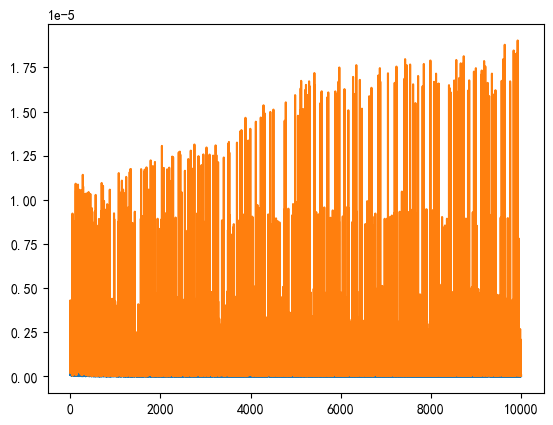

In [195]:
import matplotlib.pyplot as plt
import tqdm

num_assets = len(assets_list)

batch_size = 512
embedding_dim = 12
learning_rate = 0.09354097612272955
target_ratio = 0.015112799860696802 # 最优的target ratio 接近0 说明只选择1个资产作为目标最好
weight_decay = 1.0230687504458523e-05

minimize_window = 100
train_sample_range = train_yield.shape[1]
test_sample_range = test_yield.shape[1]

model = AssetsEmbedding(num_assets = num_assets, embedding_dim = embedding_dim, target_ratio = target_ratio).to('cuda:0')
loss_fn = nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate, weight_decay=weight_decay)

def batch(batch_size):

    # 训练
    model.train()
    batch_yield = []
    begin = np.random.randint(0, train_sample_range - minimize_window, batch_size)
    end = np.array([np.random.randint(first+minimize_window, train_sample_range) for first in begin])
    for i in range(batch_size):
        range_yield = train_yield[:, begin[i]: end[i]]
        target_yield = torch.mean(range_yield, dim = 1)
        batch_yield.append(target_yield)
    batch_yield = torch.stack(batch_yield)

    x_pred, x_real = model.pre_train(batch_yield)
    optimizer.zero_grad()
    train_loss = loss_fn(x_pred, x_real)
    train_loss.backward()
    optimizer.step()

    # 测试
    model.eval()
    with torch.no_grad():
        batch_yield = []
        begin = np.random.randint(0, test_sample_range - minimize_window, batch_size)
        end = np.array([np.random.randint(first+minimize_window,test_sample_range) for first in begin])
        for i in range(batch_size):
            range_yield = test_yield[:, begin[i]: end[i]]
            target_yield = torch.mean(range_yield, dim = 1)
            batch_yield.append(target_yield)
        batch_yield = torch.stack(batch_yield)
        x_pred, x_real = model.pre_train(batch_yield)
        test_loss = loss_fn(x_pred, x_real)
    return train_loss.cpu().detach(), test_loss.cpu().detach()

def train(round):
    train_losses = []
    test_losses = []
    for i in tqdm.tqdm(range(round)):
        train_loss, test_loss = batch(batch_size = batch_size)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    plt.plot(range(round), train_losses)
    plt.plot(range(round), test_losses)
    plt.show()

train(10000)

In [196]:
embeddings = model.embedding.weight.detach().cpu().numpy()

In [191]:
# torch.save(model.state_dict(), 'params/assets_embedding_final.params')

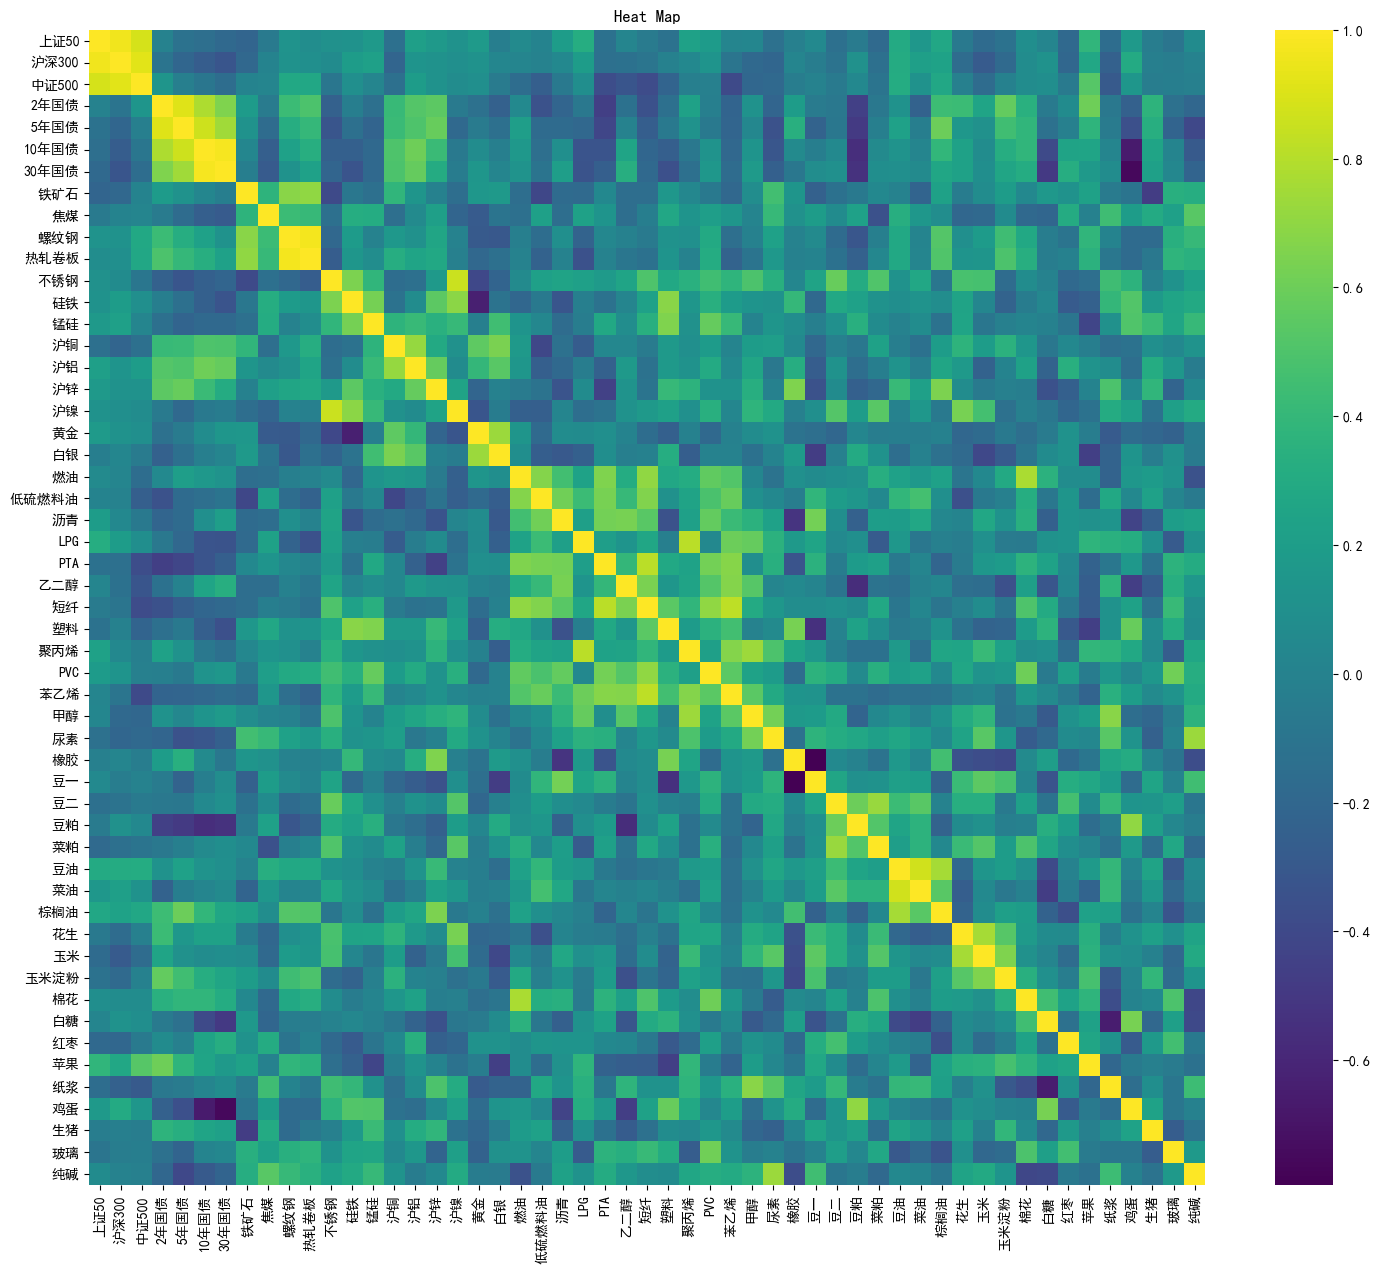

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# 画热力图
similarity_matrix = cosine_similarity(embeddings)
similarity_df = pd.DataFrame(similarity_matrix, index=assets_names, columns=assets_names)

plt.figure(figsize=(18, 15))
sns.heatmap(similarity_df, cmap='viridis', annot=False)
plt.title('Heat Map')
plt.show()

股指和国债期货分别形成了一个极其明亮的黄色方块。模型准确地识别出它们是高度相关性。同时股指方块和国债方块之间的区域是深蓝色，显示出它们之间存在极强的负相关性，符合股债轮动。此外，国债与黑色板块也呈现出极强的负相关性。

黑色板块呈现大块的矩形亮色区域，板块内呈现出极强的正相关性。这说明模型学习到了黑色产业链的相关关系；

有色金属板块是若干个小的亮色区域，暗示着有色金属之间既有替代关系也有互补关系，并非简单的同涨同跌；

能源化工板块内部，油品链 (燃油, 低硫燃料油, 沥青, LPG) 聚酯/塑料链 (PTA, 乙二醇, 短纤, 塑料, 聚丙烯, PVC) 也能分别形成两个独立的子区域

农产品板块则没有什么强的关联，大部分农产品都具有相对独立的生产区域，产业链也远不如工业品，其价格走势往往由产区的特殊气候驱动，跨资产间高度的独立性也是合理的。

但也有一些细节的关联，例如豆粕与豆二关联很强，但与豆一没什么关系，实际上豆粕也主要是用转基因的进口大豆制作的，非常合理；

而豆油虽然也是压榨的产品，但其绝对价格较高，价格的波动性与菜油、棕榈油关联性更强，反应出更强的替代关系。

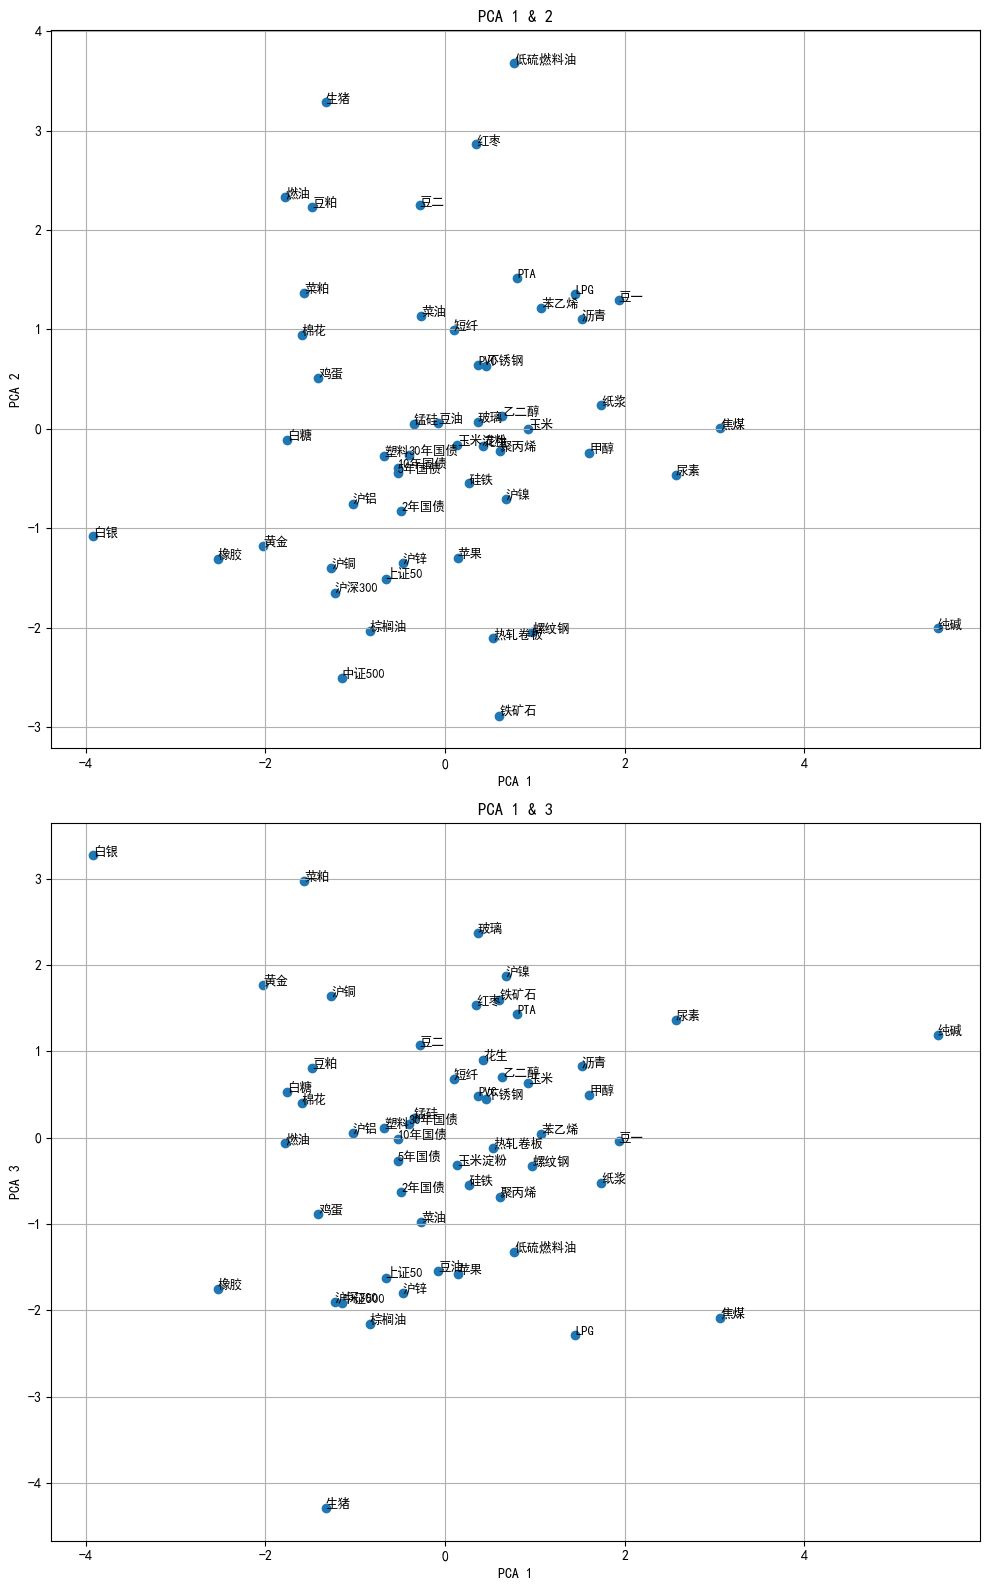

In [198]:
# PCA分析
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
embeddings_pca = pca.fit_transform(embeddings)

fig, axes = plt.subplots(2, 1, figsize=(10, 16)) # 增大图像尺寸以容纳三个子图

axes[0].scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
for i, name in enumerate(assets_names):
    axes[0].annotate(name, (embeddings_pca[i, 0], embeddings_pca[i, 1]), fontsize=9)
axes[0].set_title('PCA 1 & 2')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')
axes[0].grid(True)

axes[1].scatter(embeddings_pca[:, 0], embeddings_pca[:, 2])
for i, name in enumerate(assets_names):
    axes[1].annotate(name, (embeddings_pca[i, 0], embeddings_pca[i, 2]), fontsize=9)
axes[1].set_title('PCA 1 & 3')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 3')
axes[1].grid(True)

plt.tight_layout()
plt.show()

1. PCA 1轴 主要刻画周期性，股指期货、工业品等顺周期资产大部分都在负半轴，国债，贵金属则集中在右侧。

2. PCA 2轴 则主要划分农产品和工业品属性，大部分农产品，如生猪、菜油、豆油、棕榈油、苹果、玉米等都在正半轴，工业品则分布在负半轴。

3. PCA 3轴 可能反映了国际宏观因素的影响强弱

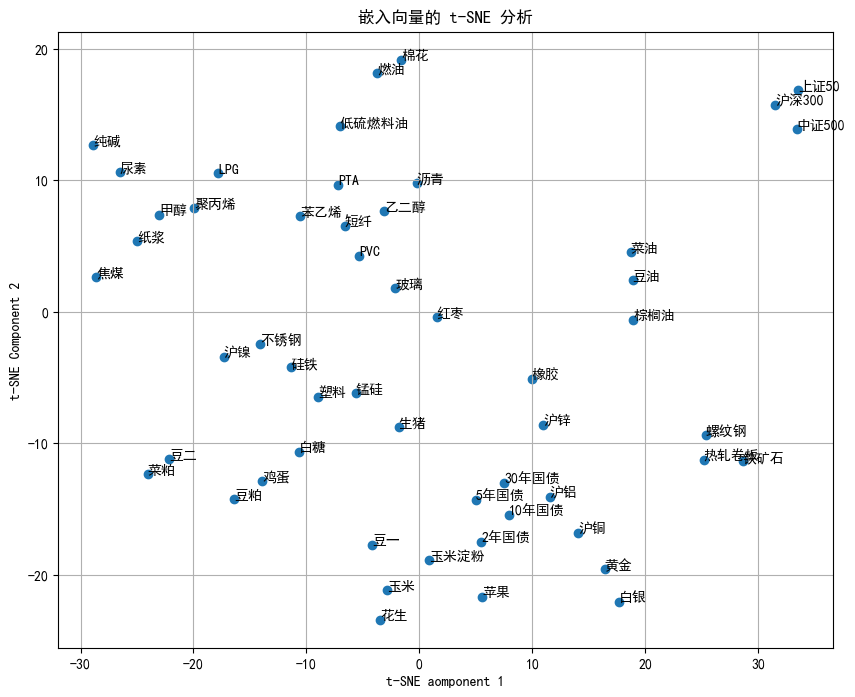

In [199]:
# tSNE分析
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
for i, name in enumerate(assets_names):
    plt.annotate(name, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))

plt.title('嵌入向量的 t-SNE 分析')
plt.xlabel('t-SNE aomponent 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

t-SNE 算法主要分析和展现相似关系，可以看到相似的资产在图上也非常接近

总体来说，该模型成功的刻画了资产之间的相关关系，以该模型得到的资产嵌入作为基础，能很好的服务大模型跨板块注意力机制的作用。